In [1]:
from functools import reduce
import operator
import math

import numpy as np

from cospar import reader, F, paramkeys, datakeys

from everest.window import Canvas
from everest.window.data import Data
from everest.analysis import time_fourier

from matplotlib.pyplot import get_cmap
%matplotlib inline

In [2]:
multidatas = []
for sinuKey in ('_built_peaskauslu-thoesfthuec', '_built_oiskeaosle-woatihoo'):
    cut = reader[reduce(operator.__and__, (
        F('f') == 1,
        F('aspect') == 1,
        F('temperatureField') == sinuKey,
        ))]
    datas = sorted(reader[cut : ('tauRef', 't', 'Nu', 'temp_av')].values())
    datas = list(filter(lambda d: 5. <= math.log10(d[0]) <= 6., datas))
    multidatas.append(datas)

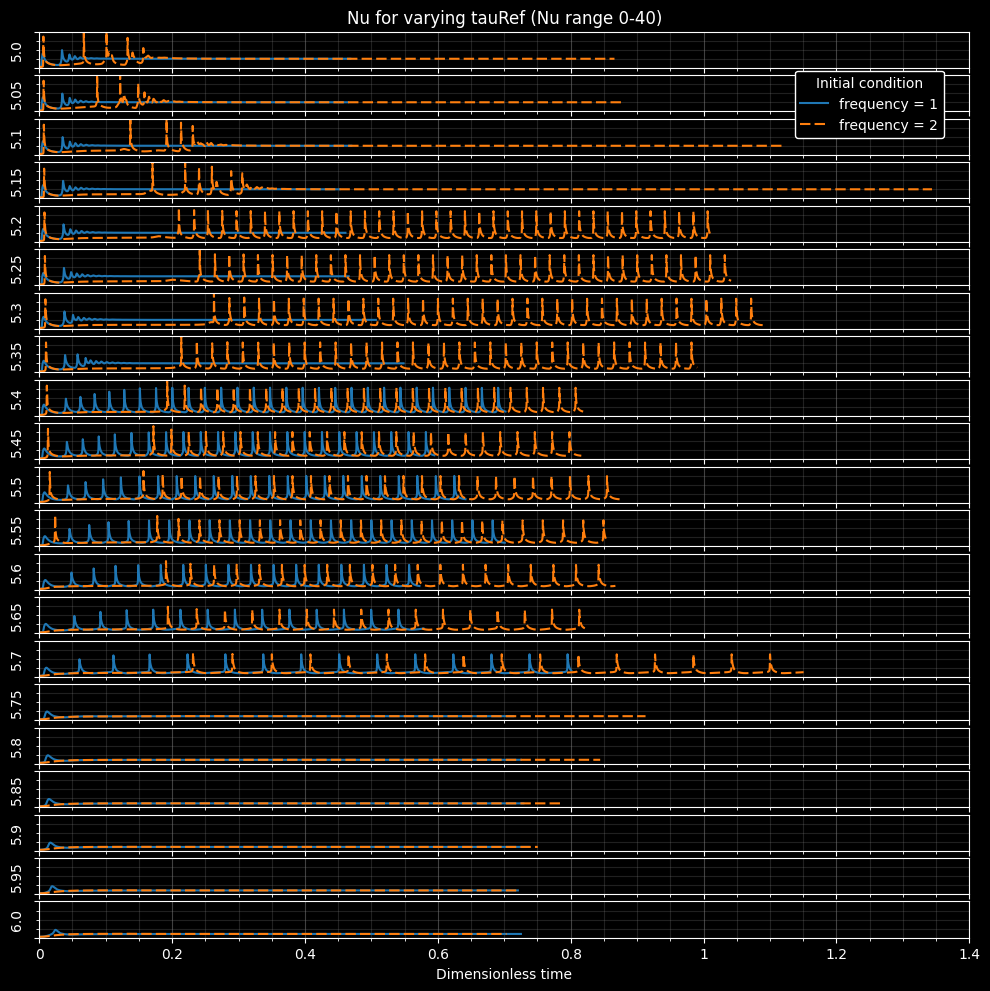

In [3]:
canvas = Canvas(size = (12, 12), shape = (len(datas), 1), facecolour = 'black')
allmaxT = max(max(d[1]) for datas in multidatas for d in datas)
ceilT = math.ceil(allmaxT * 10) / 10
for i, ((tauRef1, t1, Nu1, *_), (tauRef2, t2, Nu2, *_)) in list(enumerate(zip(*multidatas)))[::-1]:
    assert tauRef1 == tauRef2
    ax = canvas.make_ax(place = (i, 0))
    ax.line(
        Data(t1, lims = (None, ceilT), capped = (True, True)),
        Data(Nu1, lims = (0, 40), capped = (True, True)),
        )
    ax.line(
        Data(t2, lims = (None, ceilT), capped = (True, True)),
        Data(Nu2, lims = (0, 40), capped = (True, True)),
        linestyle = (0, (5, 2)),
        )
    ax.axes.y.label = str(round(math.log10(tauRef1), 2))
    ax.ticks.y.major.labels = []
    if i == len(datas) - 1:
        ax.axes.x.label = 'Dimensionless time'
    else:
        ax.ticks.x.major.labels = []
        if i == 0:
            ax.axes.title = 'Nu for varying tauRef (Nu range 0-40)'
    ax.axes.colour = 'white'
    ax.ticks.x.colour = 'white'
    ax.ticks.y.colour = 'white'
    ax.grid.colour = 'grey'

ax = canvas.axs[0][0][0]
legendHandles = [r[0] for r in ax.collections]
legendLabels = ['frequency = 1', 'frequency = 2']
handles, labels = zip(*sorted(zip(legendHandles, legendLabels), key = lambda r: r[-1]))
legend = ax.ax.legend(
    handles,
    labels,
    loc = 'right',
    framealpha = 1.,
    labelcolor = 'white',
    facecolor = 'black',
    frameon = True,
    title = 'Initial condition',
    bbox_to_anchor = (0.98, -1.0),
    )
legend.properties()['title'].set_color('white')
legend.get_frame().set_edgecolor('w')

canvas.show()

In [8]:
multiffts = []
for datas in multidatas:
    ffts = []
    for tauRef, t, Nu, *_ in datas:
#         mask = t > (max(t) * 2 ** -1.5)
        mask = t > (max(t) - max(t) * 2 ** -1.5)
        t, Nu = t[mask], Nu[mask]
        freqs, trans = time_fourier(
            t,
            Nu,
            sampleFactor = 10,
            interpKind = 'quadratic',
            minFreq = 0.01,
            maxFreq = 100.,
            minAmps = (2,),
            )
        ffts.append((tauRef, freqs, trans))
    multiffts.append(ffts)

In [5]:
# sample = multiffts[0]
# sampleFreqs, sampleTrans = dict((param, vals) for param, *vals in sample)[10 ** 5.3]
# from everest import window
# window.plot.line(sampleFreqs, sampleTrans, size = (12, 6))

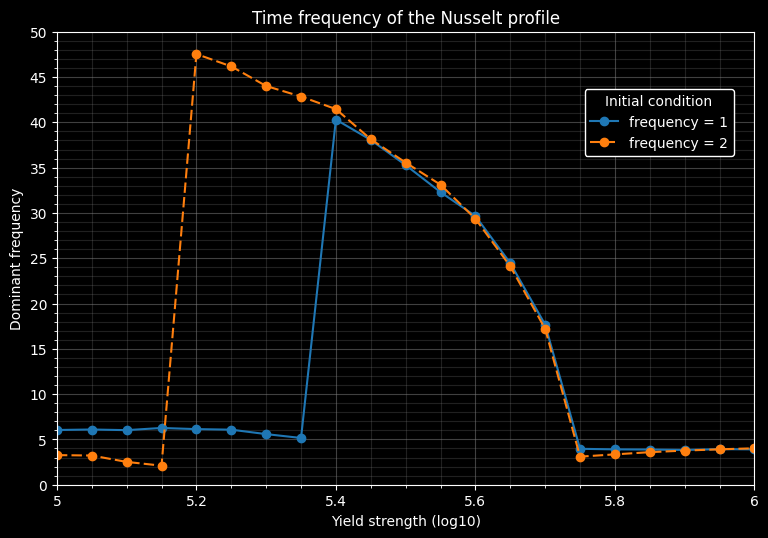

In [9]:
canvas = Canvas(size = (9, 6), facecolour = 'black')
ax = canvas.make_ax()
for ffts, linestyle in zip(multiffts, ('-', (0, (5, 2)))):
    x, y = [], []
    for tauRef, freqs, trans in ffts:
        x.append(tauRef)
        y.append(freqs[list(trans).index(np.max(trans))])
    ax.line(
        Data(np.log10(x), label = 'Yield strength (log10)', lims = (5., 6.), capped = (True, True)),
        Data(y, label = 'Dominant frequency'),
        marker = 'o',
        linestyle = linestyle,
        )
ax.axes.colour = 'white'
ax.ticks.x.colour = 'white'
ax.ticks.y.colour = 'white'
ax.grid.colour = 'grey'
ax.axes.title = 'Time frequency of the Nusselt profile'

ax = canvas.axs[0][0][0]
legendHandles = [r[0] for r in ax.collections]
legendLabels = ['frequency = 1', 'frequency = 2']
handles, labels = zip(*sorted(zip(legendHandles, legendLabels), key = lambda r: r[-1]))
legend = ax.ax.legend(
    handles,
    labels,
    loc = 'right',
    framealpha = 1.,
    labelcolor = 'white',
    facecolor = 'black',
    frameon = True,
    title = 'Initial condition',
    bbox_to_anchor = (0.98, 0.8),
    )
legend.properties()['title'].set_color('white')
legend.get_frame().set_edgecolor('w')

canvas.show()

In [7]:
# canvas = Canvas(size = (6, 4), facecolour = 'black')
# ax = canvas.make_ax()
# for ffts, linestyle in zip(multiffts, ('-', (0, (5, 2)))):
#     x, y = [], []
#     for tauRef, freqs, trans in ffts:
#         x.append(tauRef)
#         y.append(freqs[list(trans).index(np.max(trans))])
#     ax.line(
#         Data(x, label = 'Yield strength (10^n)', lims = (1e5, 1e6), capped = (True, True)),
#         Data(y, label = 'Dominant frequency'),
#         marker = 'o',
#         linestyle = linestyle,
#         )
# vals = [float(l) * 10**6 for l in ax.ticks.x.major.labels]
# ax.ticks.x.major.labels = [round(math.log10(v), 2) for v in vals]
# ax.axes.colour = 'white'
# ax.ticks.x.colour = 'white'
# ax.ticks.y.colour = 'white'
# ax.grid.colour = 'grey'
# # ax.axes.title = 'Fourier properties of the Nusselt profile'

# canvas.show()